In [1]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score
import os
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


/var/folders/zg/ds4nwmvx3kq28hn4r4zwbbw80000gp/T/ipykernel_24722/2292707060.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
ds_version = "V1_0"
annotations_file = "streetSurfaceVis_v1_0.csv"
# pred_file = "effnet_surface_quality_prediction-V1_0_s_1024-20240612_111928.csv"
root_data_path = os.path.join("..", "data", ds_version)
# root_data_path = f"/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/{ds_version}"
data_path = os.path.join(root_data_path, "metadata")
# only_validation = True

In [3]:
def compute_measures_cat(true, pred):
    return{
        "accuracy": sum(true == pred) / len(true)
    }

def compute_measures_float(true_float, pred_float):
    m = {
    "accuracy": sum(true_float.round() == pred_float.round()) / len(true_float),
    "correlation": np.corrcoef(true_float, pred_float)[0, 1],
    "r_square": r2_score(true_float, pred_float),
    "mse": mean_squared_error(true_float, pred_float)
    }
    m["rmse"] = np.sqrt(m["mse"])
    return m

In [4]:
annot = pd.read_csv(os.path.join(root_data_path, annotations_file))
annot.rename(columns={"mapillary_image_id": "image_id", "surface_type": "type_true"}, inplace=True)
annot = annot[(annot.train == True)]

# print(annot)

In [7]:
# df_blur = pd.DataFrame(
#     {"epoch": [6, 7, 10, 9, 13, 15],
#      "lr": [3, 3, 3, 1, 1, 1],
#     },
# )

df_blur = pd.DataFrame(
    {"run": [1, 2, 3, 4, 5, 6, 7, 8],
    },
)

gm_valid = np.zeros((df_blur.shape[0], 1))

cm_valid = np.zeros((df_blur.shape[0], 5, 5), dtype=int)

classification = pd.DataFrame()


yticklabels = []
xticklabels = ["V1_0 high blur"]

for index_y, row_m in df_blur.iterrows():
    # index_m = df_blur[(df_blur["kernel"]==row_m['kernel']) & (df_blur["sigma"]==row_m['sigma'])]["model_dataset"].values[0]
    # print(index_m)
    # yticklabels.append(f"model_k_{row_m['kernel'] if row_m['kernel'] != 0 else None}_s_{row_m['sigma'] if row_m['sigma'] != 0 else None}")
    run = row_m["run"]
    yticklabels.append(f"model_run_{row_m['run']}")
    
    # kernel = row_d["kernel"] if row_d["kernel"] != 0 else None
    # sigma = row_d["sigma"] if row_d["sigma"] != 0 else None
    name = f"effnet_high_blur_surface_pred_V1_0_run{run}-"
    pred_file = ""
    for root, _, fnames in sorted(os.walk(data_path, followlinks=False)):
        for fname in sorted(fnames):
            if name in fname and fname.endswith('.csv'):
                pred_file = os.path.join(root, fname)
                print(pred_file)
    if pred_file == "":
        raise ValueError(f"no prediction file found for run {run}")
    
    pred = pd.DataFrame()

    print(f"reading {pred_file}")
    pred = pd.read_csv(pred_file)
    pred.rename(columns={"Image": "image_id",  "Level_0": "type_pred"}, inplace=True)

    type_pred = pred[pred.Level == "type"][["image_id", "Prediction", "type_pred", "is_in_validation"]]
    type_pred.rename(columns={"Prediction": "class_prob"}, inplace=True)
    idx = type_pred.groupby("image_id")["class_prob"].idxmax()
    type_pred = type_pred.loc[idx].reset_index()

    df = type_pred.set_index("image_id").join(annot[["image_id", "type_true"]].set_index("image_id"), how="left")
    df = df[df.is_in_validation == 1]
    
    gm = compute_measures_cat(df.type_true, df.type_pred)
    gm_valid[index_y] = round(gm['accuracy'], 3)

    cm = confusion_matrix(df.type_true, df.type_pred, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
    cm_valid[index_y, :, :] = cm

#     # misclassification
#     if (index_m == 0):
#         classification["image_id"] = type_pred["image_id"]
#         classification["type_true"] = type_pred["type_true"]
#         classification.set_index("image_id", inplace=True)
#         classification = classification.join(type_pred[["image_id", "is_in_validation"]].set_index("image_id"), how="left")

#     column = f"model_k_{row_m['kernel'] if row_m['kernel'] != 0 else None}_s_{row_m['sigma'] if row_m['sigma'] != 0 else None}"
#     type_pred.rename(columns={"type_pred": column}, inplace=True)
#     classification = classification.join(type_pred[["image_id", column]].set_index("image_id"), how="left")
# classification.to_csv(os.path.join(data_path, "model_predictions", "classification_blur.csv"), index=True)


../data/V1_0/metadata/effnet_high_blur_surface_pred_V1_0_run1-V1_0_annotated-20240703_174222.csv
reading ../data/V1_0/metadata/effnet_high_blur_surface_pred_V1_0_run1-V1_0_annotated-20240703_174222.csv
../data/V1_0/metadata/effnet_high_blur_surface_pred_V1_0_run2-V1_0_annotated-20240703_174609.csv
reading ../data/V1_0/metadata/effnet_high_blur_surface_pred_V1_0_run2-V1_0_annotated-20240703_174609.csv
../data/V1_0/metadata/effnet_high_blur_surface_pred_V1_0_run3-V1_0_annotated-20240703_174955.csv
reading ../data/V1_0/metadata/effnet_high_blur_surface_pred_V1_0_run3-V1_0_annotated-20240703_174955.csv
../data/V1_0/metadata/effnet_high_blur_surface_pred_V1_0_run4-V1_0_annotated-20240703_175340.csv
reading ../data/V1_0/metadata/effnet_high_blur_surface_pred_V1_0_run4-V1_0_annotated-20240703_175340.csv
../data/V1_0/metadata/effnet_high_blur_surface_pred_V1_0_run5-V1_0_annotated-20240703_175726.csv
reading ../data/V1_0/metadata/effnet_high_blur_surface_pred_V1_0_run5-V1_0_annotated-20240703_1

In [8]:
gm_valid.shape

(8, 1)

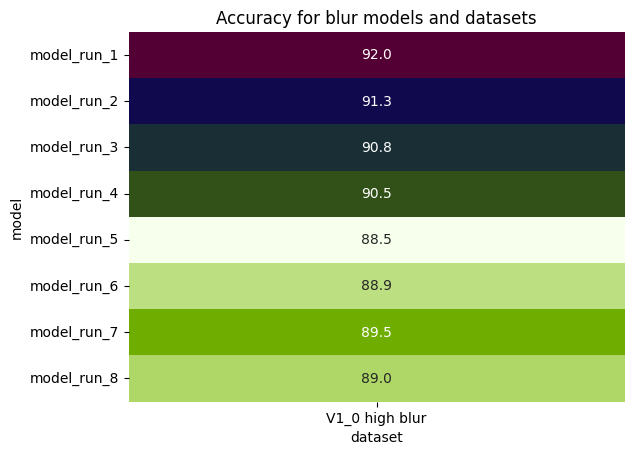

In [9]:
cmap = LinearSegmentedColormap.from_list("mycmap", ["#F7FFED", "#76B900", "#456D00", "#000B53", "#530035"])

plt.figure()
sns.heatmap(gm_valid*100, annot=True, fmt=".1f", cmap=cmap, cbar=False,
            xticklabels=xticklabels,
            yticklabels=yticklabels)
plt.title(f"Accuracy for blur models and datasets")
plt.xlabel("dataset")
plt.ylabel("model")
# plt.savefig("blur_v1_0.png", transparent=True, bbox_inches='tight')
plt.show()

# Confusion Matrix

In [10]:
def plot_conf_matrix(cm, model, dataset):
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"],
                yticklabels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
    plt.title(f"Confusion Matrix for model {model} and dataset {dataset}")
    plt.xlabel("Predicted")
    plt.ylabel("Annotated")
    plt.show()

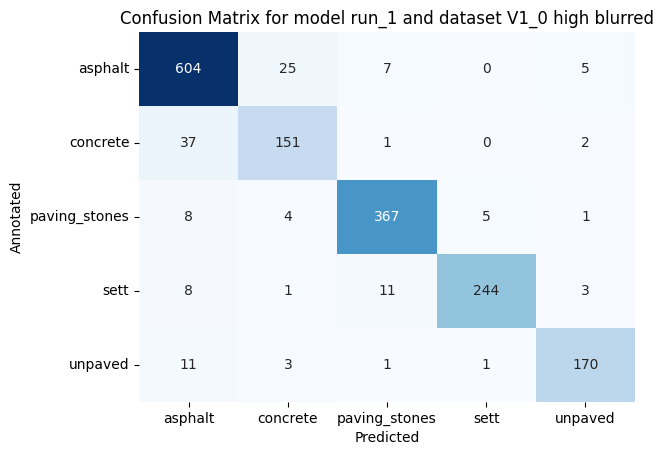

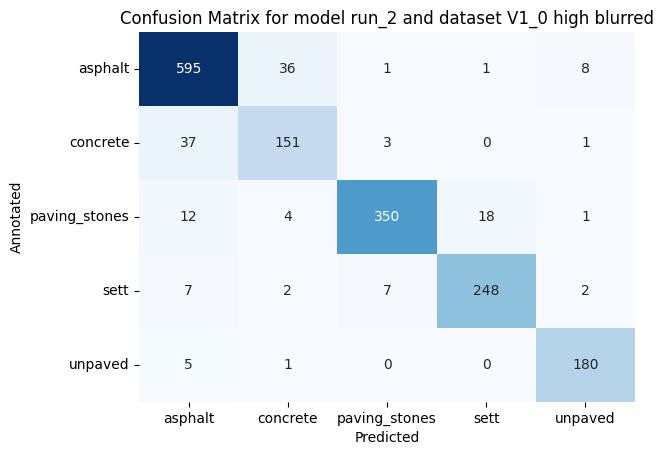

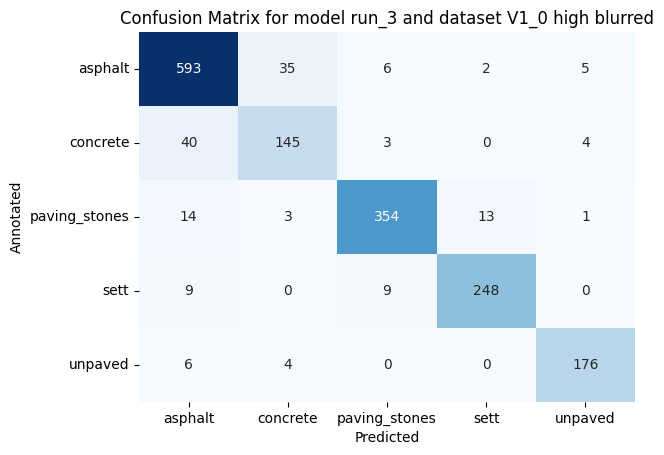

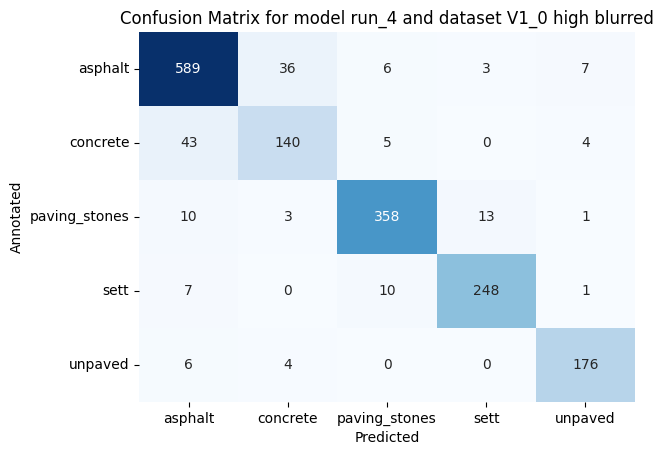

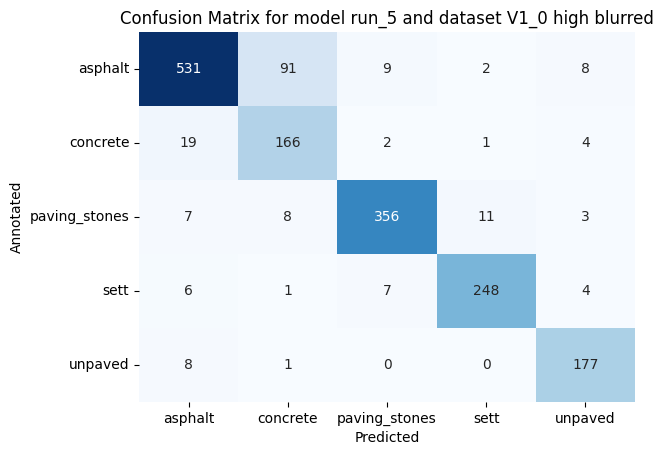

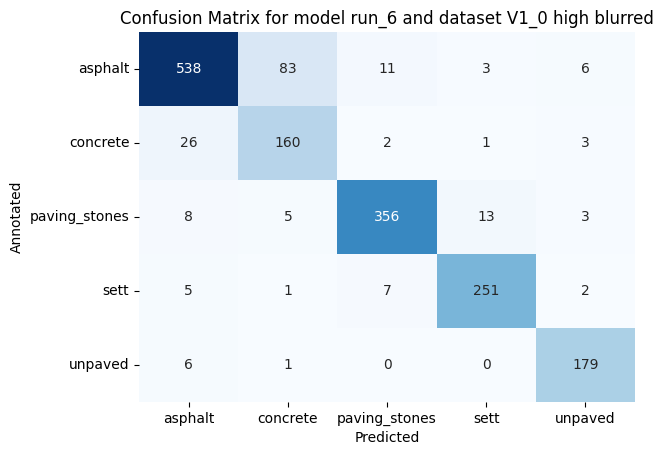

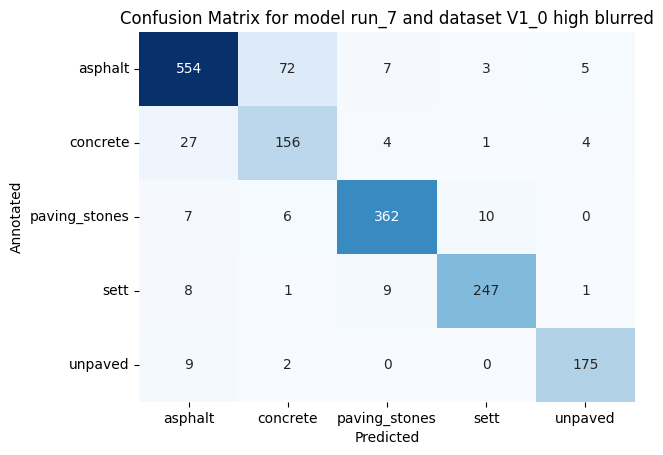

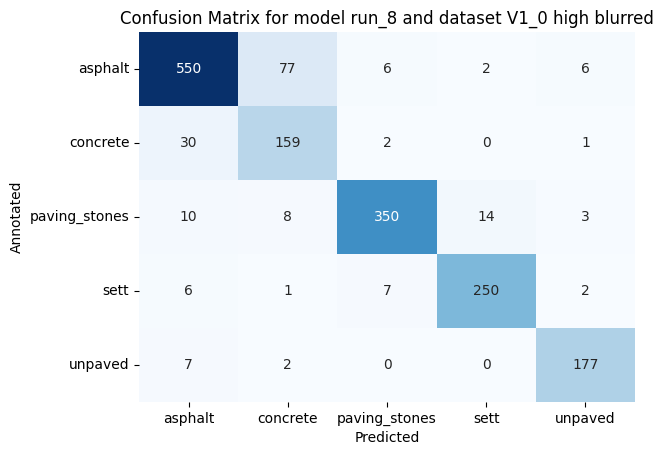

In [11]:
# k_5 s_2 & k_11 s_5

for index_y, model_row in df_blur.iterrows():

        plot_conf_matrix(cm_valid[index_y, :, :], f"run_{model_row['run']}", "V1_0 high blurred")

# Misclassified

In [ ]:
# # all images that were incorrectly classified
# misclassification = df[(df.surface_label_pred != df.surface_true) & (df.is_in_validation == 1)]

# misclassification = misclassification.sort_values("image_id")
# misclassification.reset_index( inplace=True)
# misclassification[["image_id", "is_in_validation", 
#                    "surface_true", "surface_label_pred", "quality_label_true"]
#                    ].to_csv(os.path.join(data_path, "model_predictions", "misclassification_surface.csv"), index=False)